# CARTHE errors diagnostics
- identify and filter outliers
- distribution of errors
- visual estimation of correlation

An objective quantification of errors correlations is difficult because it requieres a method to compute irregular time sampling series correlation (piste: https://pastas.readthedocs.io/en/v0.15.0/examples/017_Autocorrelation.ipynb.html)

In [1]:
import os
import math
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cmx

import pynsitu as pin
from pynsitu.maps import crs
image_dir = '/Users/mdemol/ownCloud/PhD/images/carthe_noise'

colors = pin.get_cmap_colors(21, cmap="rainbow")
from cycler import cycler
plt.rc("axes", prop_cycle=cycler(color=colors))

In [38]:
def read_carthe_drifters(file):
    
    df = pd.read_csv(file, parse_dates=[1])
    
    df = (df
          .rename(columns=dict(DeviceName="id", DeviceDateTime="time", 
                               Latitude="lat", Longitude="lon"))
          .sort_values("id")
         )
    df = df.set_index("id")
        
    return df

ids = ['0-4351902','0-4351296',#
       '0-4388581', '0-4388675', '0-4388627', '0-4388605', '0-4388608', '0-4388635', '0-4388620', '0-4388599',
       '0-4351906', '0-4388557', '0-4367307', '0-4367707', '0-4356534', '0-4367310', '0-4367706', '0-4367683', '0-4351945', '0-4356456', '0-4388554',]

---

## Load drifters trajectories

`drifters_bin.csv` is a binary csv file and it was converted into an ascii csv file with:

```
cat drifters_bin.csv | tr -d '\0' > drifters.csv
```



In [39]:
drifter_file = os.path.join('/Users/mdemol/code/PhD/carthe_noise', "carthe_noise_ok.csv")
df = read_carthe_drifters(drifter_file).reset_index().set_index('time').sort_values('time')
df.head()

,id,BatteryStatus,CommId,GPS Confidence,GPS Fail Counter,GpsQuality,lat,lon
time,,,,,,,,
2023-03-07 10:10:14,0-4351906,GOOD,0-4351906,0,0,3,48.357964,-4.560463
2023-03-07 10:11:03,0-4388557,GOOD,0-4388557,0,0,3,48.357943,-4.560592
2023-03-07 10:11:18,0-4351902,GOOD,0-4351902,0,0,3,48.357922,-4.560485
2023-03-07 10:11:41,0-4367307,GOOD,0-4367307,0,0,3,48.357911,-4.560463
2023-03-07 10:11:42,0-4367707,GOOD,0-4367707,0,0,3,48.357922,-4.560378


____
## Remove Gps Quality =1 0.0 values

In [40]:
df = df[df.GpsQuality != 1]

___________
# Projections

In [41]:
## PROJECTION

lonlat_ref = (df.lon.median(), df.lat.median())

def projection_(df, lonlat_ref=None):
    # INDEX TIME ?
    if not df.index.name == "time":
        warnings.warn("Are you sure time is the index ? ", UserWarning)
    # SORTED TIME ?
    if not df.index.is_monotonic_increasing:
        warnings.warn("time sorting dataframe", UserWarning)
        df.sort_index()
    if lonlat_ref == None :
        lonlat_ref=(df.lon.median(), df.lat.median())
    #_geo = pin.geo.GeoAccessor(df)
    df.geo.set_projection_reference(lonlat_ref)
    #_geo.set_projection_reference(lonlat_ref)
    #print(df.geo.projection_reference)
    #_geo.project()
    df.geo.project()                           
    return df
    
def project_df(df):
    df1 = df.groupby("id").apply(projection_).reset_index(level=0,drop=True)# x, y position compare to the trajectory median
    df2 = df.groupby("id").apply(projection_, lonlat_ref = lonlat_ref).reset_index(level=0,drop=True)# X,Y position compare to the total median (same for all)
    if 'X' in df2:
        df2.drop(['X','Y'], axis=1, inplace=True)
    
    df2 = df2.rename(columns={'x':'X', 'y':'Y'})
    
    if 'X' in df1 :
        df1.drop(['X','Y'], axis=1, inplace=True)
    if 'X' in df :
        df.drop(['X','Y'], axis=1, inplace=True)
        
    #print(df1.columns)
    #print(df2.columns)
    return pd.concat([df1, df2[['X', 'Y']]], axis=1)

df = project_df(df)
df['r'] = np.sqrt(df.x**2+df.y**2)
df['R'] = np.sqrt(df.X**2+df.Y**2)

_____
# Identifying outliers

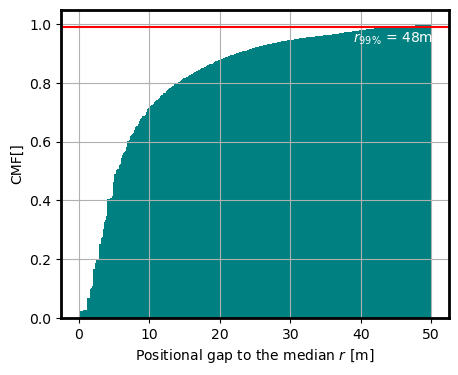

In [89]:
fig = plt.figure(figsize=(5, 4))
abs(df.r).hist(cumulative=True, bins=np.linspace(0,50, 1000), density=True, color='teal')
plt.xlabel(r'Positional gap to the median $r$ [m]')
plt.ylabel(r'CMF[]')
plt.axhline(0.99, color='red')
plt.annotate(r'$r_{99\%}$ = ' + f'{round(df.r.quantile(0.99))}m', (38.9,0.94), color='w')
fig.savefig(os.path.join(image_dir, 'r_cmf.png'), dpi=250)

_____
# Filtering Outliers (99% quantile)

In [43]:
def filter_outliers(df) : 
    df = df.copy()
    cut = df.r.quantile(0.99)
    for key in ["lon","lat", 'x', 'y', 'X', 'Y', 'r', 'R']:
        # replace by nan
        df[key] = df[key].where(df.r<cut, np.nan)    
    return df
    
df = filter_outliers(df)

_____
# Gap from mean values

In [44]:
def mean_pos_dxy(df):
    df['mean_X'] = df.X.mean()# mean position for each traj
    df['mean_Y'] = df.Y.mean()
    df['dX'] = df.X- df.mean_X# gap from position
    df['dY'] = df.Y- df.mean_Y
    df['dR'] = np.sqrt(df.dX**2+ df.dY**2)
    return df
df =df.groupby('id').apply(mean_pos_dxy).reset_index(level=0,drop=True)
df.head()

,id,BatteryStatus,CommId,GPS Confidence,GPS Fail Counter,GpsQuality,lat,lon,x,y,X,Y,r,R,mean_X,mean_Y,dX,dY,dR
time,,,,,,,,,,,,,,,,,,,
2023-03-07 10:13:13,0-4351296,GOOD,0-4351296,0,0,3,48.357911,-4.560463,0.000000,0.000000,1.630370,-1.223170e+00,0.000000,2.038198,3.883549,2.281121,-2.253180,-3.504291,4.166158
2023-03-07 10:17:33,0-4351296,GOOD,0-4351296,0,0,3,48.357943,-4.560506,-3.186630,3.558314,-1.556261,2.335143e+00,4.776631,2.806215,3.883549,2.281121,-5.439811,0.054022,5.440079
2023-03-07 10:22:32,0-4351296,GOOD,0-4351296,0,0,3,48.357964,-4.560528,-4.816997,5.893458,-3.186629,4.670287e+00,7.611590,5.653864,3.883549,2.281121,-7.070178,2.389166,7.462944
2023-03-07 10:27:33,0-4351296,GOOD,0-4351296,0,0,3,48.357922,-4.560506,-3.186631,1.223171,-1.556262,2.131328e-07,3.413322,1.556262,3.883549,2.281121,-5.439811,-2.281121,5.898734
2023-03-07 10:32:33,0-4351296,GOOD,0-4351296,0,0,3,48.357932,-4.560506,-3.186631,2.335144,-1.556261,1.111973e+00,3.950634,1.912703,3.883549,2.281121,-5.439811,-1.169148,5.564032


<Figure size 500x400 with 0 Axes>

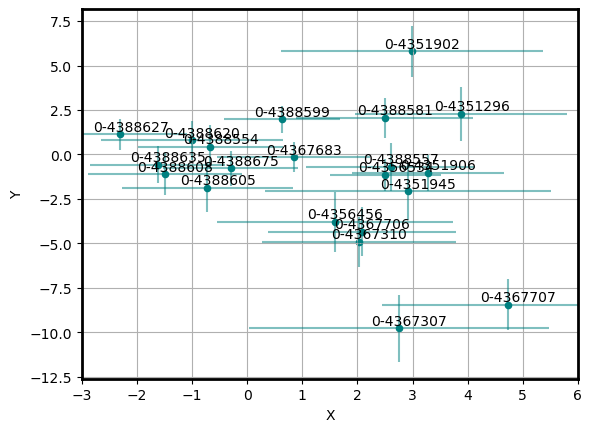

In [101]:
dfm = df[["id", "X", "Y", "lon", "lat"]].groupby('id').mean()
error_on_mean = df[['X', 'Y', 'id']].groupby('id').std()/np.sqrt(df[['X', 'Y', 'id']].groupby('id').count()/12)

fig = plt.figure(figsize=(5,4))
dfm.plot.scatter('X', 'Y', color='teal')
plt.errorbar(dfm.X, dfm.Y, error_on_mean.X.values, error_on_mean.Y.values, ls='', color = 'teal', alpha=0.5)
plt.grid()
for id_ in ids : 
    dfm_=dfm.loc[id_]
    plt.annotate(id_, (dfm_.X-0.5, dfm_.Y+0.2))
plt.xlim(-3,6)
fig.savefig(os.path.join(image_dir, 'mean_pos_errorbars.png'), dpi=250)

<Figure size 500x400 with 0 Axes>

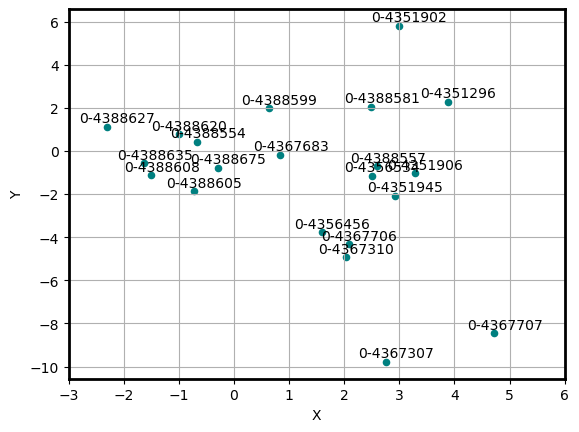

In [87]:
dfm = df[["id", "X", "Y", "lon", "lat"]].groupby('id').mean()
error_on_mean = df[['X', 'Y', 'id']].groupby('id').std()/np.sqrt(df[['X', 'Y', 'id']].groupby('id').count())

fig = plt.figure(figsize=(5,4))
dfm.plot.scatter('X', 'Y', color='teal')
#plt.errorbar(dfm.X, dfm.Y, error_on_mean.X.values, error_on_mean.Y.values, ls='', color = 'teal', alpha=0.5)
plt.grid()
for id_ in ids : 
    dfm_=dfm.loc[id_]
    plt.annotate(id_, (dfm_.X-0.5, dfm_.Y+0.2))
plt.xlim(-3,6)
fig.savefig(os.path.join(image_dir, 'mean_pos.png'), dpi=250)

________
# Errors from mean position dX dY

ok
ok
ok
ok


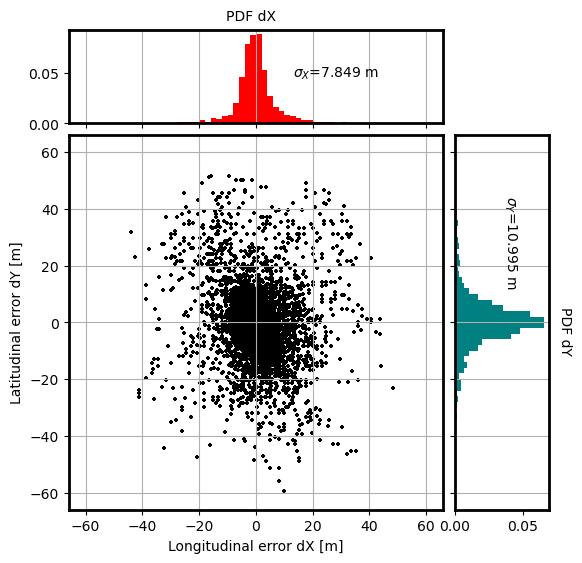

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# some random data
x = np.array(df.dX.dropna())# CAUTION : remove the extreme outlier
y = np.array(df.dY.dropna())


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, marker='+', color='k', s=6)
    print('ok')
    # now determine nice limits by hand:
    binwidth = 2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    print('ok')
    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, density=True, color='red')
    ax_histy.hist(y, bins=bins, orientation='horizontal', density=True, color='teal')

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
print('ok')
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
print('ok')


rmsx = df.dX.std()
rmsy = df.dY.std()

# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)
ax.grid()
ax_histx.grid(axis = 'x')
ax_histy.grid(axis = 'y')
#ax_histx.set_yscale('log')
#ax_histy.set_xscale('log')
ax.set_xlabel('Longitudinal error dX [m]')
ax.set_ylabel('Latitudinal error dY [m]')
ax_histx.annotate('PDF dX', (0.42,1.1), xycoords = 'axes fraction')
ax_histy.annotate('PDF dY', (1.1,0.42), xycoords = 'axes fraction', rotation=270)
ax_histx.annotate(r'$\sigma_{X}$'+ f'={round(rmsx,3)} m', (0.6,0.5), xycoords = 'axes fraction')
ax_histy.annotate(r'$\sigma_{Y}$'+ f'={round(rmsy,3)} m', (0.5,0.6), xycoords = 'axes fraction', rotation=270)


fig.savefig(os.path.join(image_dir, 'carthe_dxdy_distribution.png'), dpi=250)

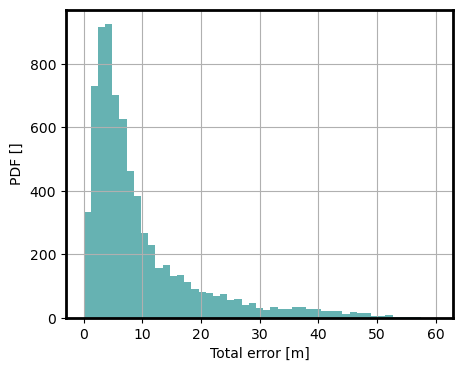

In [96]:
fig = plt.figure(figsize=(5,4))
df.dR.hist(bins = np.linspace(0, 60, 50), color='teal', alpha = 0.6, label='Norm of the error')
plt.xlabel('Total norm error [m]')
plt.ylabel('PDF []')

fig.savefig(os.path.join(image_dir, 'carthe_R.png'), dpi=250)

## Distance to the mean position overview

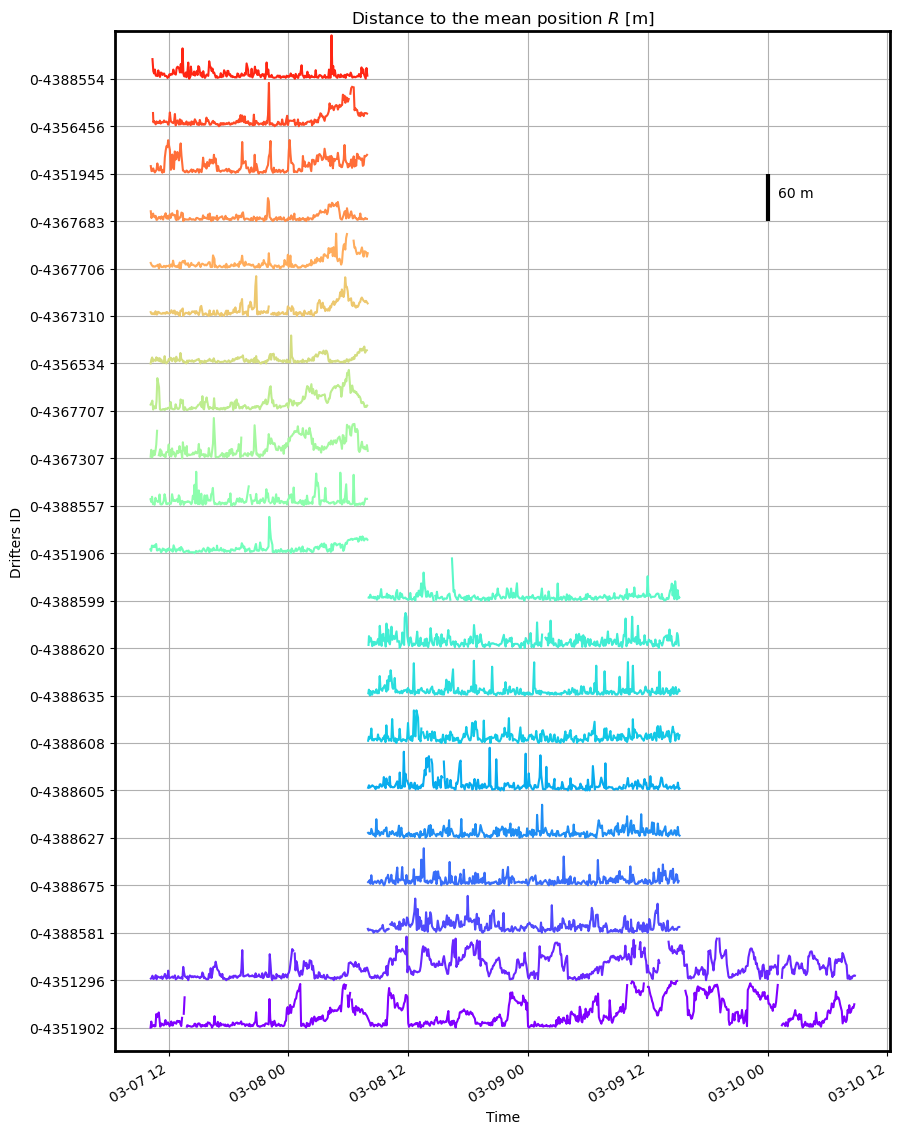

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(10,15))
i=0
for id_ in ids:
    df_=df[df.id==id_]
    (df_.R+i).plot(  ax=ax, label=id_)
    i+=60

ax.vlines(pd.to_datetime('03-10-2023'),17*60, 18*60, color='k', lw=3)
ax.annotate('60 m', (pd.to_datetime('01:00 03-10-2023'), 17.5*60), color='k')
ax.grid()
ax.set_title('Distance to the mean position $R$ [m]')
ax.set_yticks(np.arange(0,60*len(ids), 60), labels = ids)
ax.set_ylim(-30, 60*len(ids))
ax.set_ylabel('Drifters ID')
ax.set_xlabel('Time')
fig.savefig(os.path.join(image_dir, 'carthe_R_traj.png'), dpi=250)

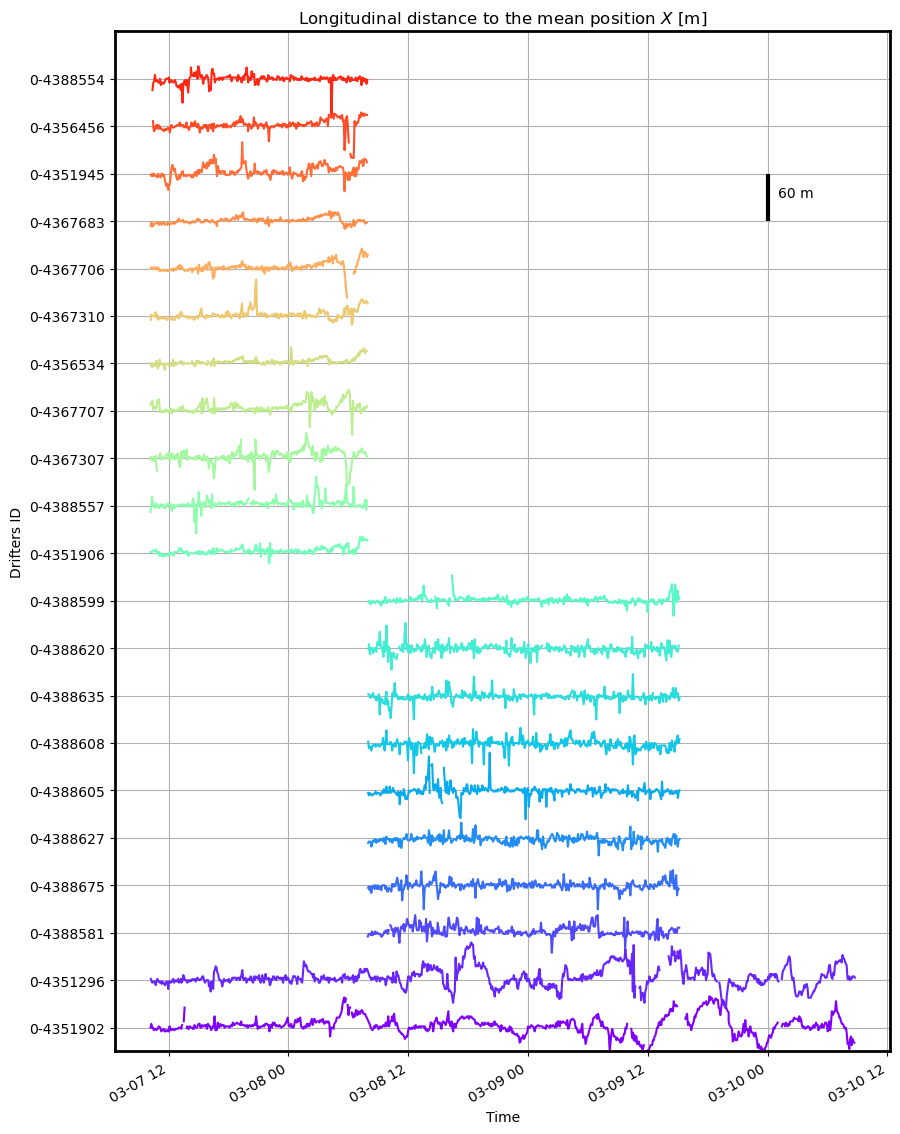

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(10,15))
i=0
for id_ in ids:
    df_=df[df.id==id_]
    (df_.X+i).plot(  ax=ax, label=id_)
    i+=60

ax.vlines(pd.to_datetime('03-10-2023'),17*60, 18*60, color='k', lw=3)
ax.annotate('60 m', (pd.to_datetime('01:00 03-10-2023'), 17.5*60), color='k')
ax.grid()
ax.set_title('Longitudinal distance to the mean position $X$ [m]')
ax.set_yticks(np.arange(0,60*len(ids), 60), labels = ids)
ax.set_ylim(-30, 60*len(ids))
ax.set_ylabel('Drifters ID')
ax.set_xlabel('Time')
fig.savefig(os.path.join(image_dir, 'carthe_X_traj.png'), dpi=250)

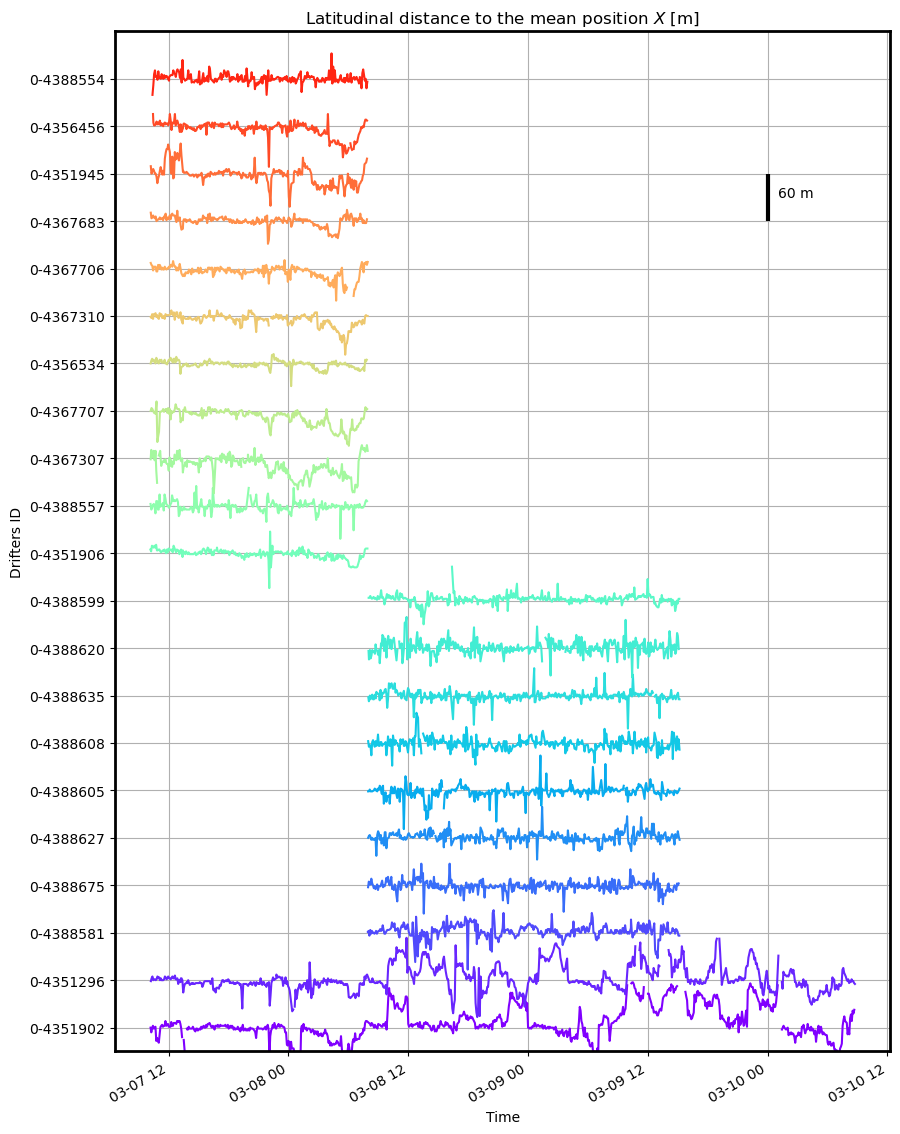

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(10,15))
i=0
for id_ in ids:
    df_=df[df.id==id_]
    (df_.Y+i).plot(  ax=ax, label=id_)
    i+=60

ax.vlines(pd.to_datetime('03-10-2023'),17*60, 18*60, color='k', lw=3)
ax.annotate('60 m', (pd.to_datetime('01:00 03-10-2023'), 17.5*60), color='k')
ax.grid()
ax.set_title('Latitudinal distance to the mean position $X$ [m]')
ax.set_yticks(np.arange(0,60*len(ids), 60), labels = ids)
ax.set_ylim(-30, 60*len(ids))
ax.set_ylabel('Drifters ID')
ax.set_xlabel('Time')
fig.savefig(os.path.join(image_dir, 'carthe_Y_traj.png'), dpi=250)